# Python Code Readability

Will Tholke, Alex Truong, Andrew Zhang

## Imports

In [1]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import math
import re
from scipy.stats import norm

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!python -m nltk.downloader punkt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/willtholke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Loading & Pre-processing

In [3]:
def preprocess(text):
    cleaned_text = text.replace('<newline>', '\n')
    return cleaned_text

In [4]:
def load_ordinal_data(filename, ordering):
    x = []
    y = []
    orig_y = []

    for _ in ordering:
        y.append([])

    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            preprocess(text)
            x.append(text)

            index = ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    y[i].append(1)
                else:
                    y[i].append(0)
            orig_y.append(label)

    return x, y, orig_y

## Ordinal Classifier Definition

In [5]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, train_x, train_y, dev_x, dev_y, test_x, test_y, orig_train_y, orig_dev_y, orig_test_y):
        self.ordinal_values = ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count = 2
        self.log_regs = [None] * (len(self.ordinal_values)-1)

        self.train_y = train_y
        self.dev_y = dev_y
        self.test_y = test_y

        self.orig_train_y = orig_train_y
        self.orig_dev_y = orig_dev_y
        self.orig_test_y = orig_test_y

        self.train_x = self.process(train_x, training=True)
        self.dev_x = self.process(dev_x, training=False)
        self.test_x = self.process(test_x, training=False)

        self.predictions = []

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, x_data, training = False):

        data = self.featurize(x_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat] += 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        f = len(self.feature_vocab)
        d = len(data)
        x = sparse.dok_matrix((d, f))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    x[idx, self.feature_vocab[feat]] = feats[feat]

        return x

    def train(self):
        # (D,F) = self.train_x.shape

        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy = 0
            best_model = None
            for C in [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100, 1000]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.train_x, self.train_y[idx])

                development_accuracy = log_reg.score(self.dev_x, self.dev_y[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg

            self.log_regs[idx] = best_model

    def test(self):
        cor = tot = 0
        counts = Counter()
        preds = [None]*(len(self.ordinal_values)-1)

        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx] = self.log_regs[idx].predict_proba(self.test_x)[:,1]

        preds = np.array(preds)

        for data_point in range(len(preds[0])):
            ordinal_preds = np.zeros(len(self.ordinal_values))

            for ordinal in range(len(self.ordinal_values) - 1):
                if ordinal == 0:
                    ordinal_preds[ordinal] = 1 - preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal] = preds[ordinal-1][data_point]-  preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values) - 1] = preds[len(preds) - 1][data_point]

            prediction=np.argmax(ordinal_preds)
            self.predictions.append(prediction+1)

            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_test_y[data_point]):
                cor+=1
            tot+=1

        return cor/tot

## Feature Encoding

### Feature 1: Code Length and Repetition (Section 2.1)

In [6]:
def check_line_length(text, code_max_length=79, docstring_max_length=72):
    """ Check if lines of code, docstrings, and inline comments do not exceed their maximum allowable lengths. """
    lines = text.split('\n')
    for line in lines:
        if len(line) > code_max_length:
            return False
        if line.startswith('#') or line.strip().startswith('"""') or line.strip().startswith("'''"):
            if len(line) > docstring_max_length:
                return False
    return True

### Feature 2: Inline Comments and Docstrings (Section 2.2)

In [7]:
def check_comments_docstrings(text):
    """ Check if at least one of the following is present: docstring, inline comment, assert statement, error handling. """
    if re.search(r'"""(.|\n)*?"""', text) or re.search(r"'''(.|\n)*?'''", text) or re.search(r'#', text):
        return True
    # Omitted: checks for assert statements and error handling

    return False

### Feature 3: Naming Conventions and Case (Section 2.3)

In [8]:
def check_naming_conventions(text):
    """ Check if the class name is in CamelCase or the function name is in snake_case. Check if variables are in snake_case. """
    if not (re.search(r'\bclass\s+[A-Z][a-zA-Z0-9]*', text) or re.search(r'\bdef\s+[a-z_][a-zA-Z0-9]*', text)):
        return False

    variable_pattern = r'\b[a-z][a-zA-Z0-9_]*\s*='
    variable_matches = re.findall(variable_pattern, text)

    for match in variable_matches:
        var_name = match.strip().rstrip('=').strip()
        if not re.match(r'^[a-z][a-zA-Z0-9_]*$', var_name):
            return False

    return True

def check_descriptive_params(text):
    """ Check if function and class parameters are self-explanatory. """
    bad_params = {'x', 'y', 'temp', 'param', 'input', 'temp', 'i', 'j', 'k'}
    function_pattern = r'\bdef\s+[a-z_][a-zA-Z0-9]*\s*\((.*?)\)'
    class_pattern = r'\bclass\s+[A-Z][a-zA-Z0-9]*\s*\((.*?)\)'
    function_matches = re.findall(function_pattern, text)
    class_matches = re.findall(class_pattern, text)

    for params in function_matches + class_matches:
        param_list = [p.strip() for p in params.split(',')]
        for param in param_list:
            if param in bad_params:
                return False
    return True

### Feature 4: Whitespace (Section 2.4)

In [9]:
def check_whitespace(text):
    """ Check for consistency between tabs and spaces for indentation. """
    lines = text.split('\n')
    space_indented = [line.startswith(' ') for line in lines if line.strip()]
    tab_indented = [line.startswith('\t') for line in lines if line.strip()]
    return not (any(space_indented) and any(tab_indented))

def check_blank_lines(text):
    """ Check whether blank lines are used sparingly. """
    lines = text.split('\n')
    blank_line = 0

    for line in lines:
        if not line.strip():
            blank_line += 1
            if blank_line > 1:
                return False
        else:
            blank_line = 0

    return True

### Feature 5: Miscellaneous (Section 2.5)

In [10]:
def check_misc(text):
    """ Check for residual to-do statements and comparison of boolean values. """
    if re.search(r'\bTrue\b', text) or re.search(r'\bFalse\b', text) or re.search(r'todo', text, re.IGNORECASE):
        return False
    return True

## Feature Combination

In [11]:
def readability_features(text):
    features = {
        'line_length': check_line_length(text),
        'comments_docstrings': check_comments_docstrings(text),
        'naming_conventions': check_naming_conventions(text),
        'descriptive_params': check_descriptive_params(text),
        'whitespace_consistency': check_whitespace(text),
        'blank_lines': check_blank_lines(text),
        'misc': check_misc(text),
    }
    return features

## Training

In [12]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [13]:
class RunObject:

    def __init__(self, train_x, train_y, orig_train_y, test_x, test_y, orig_test_y, classifier, preds):
        self.train_x = train_x
        self.train_y = train_y
        self.orig_train_y = orig_train_y

        self.test_x = test_x
        self.test_y = test_y
        self.orig_test_y = orig_test_y

        self.classifier = classifier
        self.preds = preds

def run(training_file, dev_file, test_file, ordinal_values, return_run_obj=None):
    train_x, train_y, orig_train_y = load_ordinal_data(training_file, ordinal_values)
    dev_x, dev_y, orig_dev_y = load_ordinal_data(dev_file, ordinal_values)
    test_x, test_y, orig_test_y = load_ordinal_data(test_file, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, readability_features, train_x, train_y, dev_x, dev_y, test_x, test_y, orig_train_y, orig_dev_y, orig_test_y)
    simple_classifier.train()
    accuracy = simple_classifier.test()

    lower, upper = confidence_intervals(accuracy, len(test_y[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    return RunObject(train_x, train_y, orig_train_y, test_x, test_y, orig_test_y, simple_classifier, simple_classifier.predictions) if return_run_obj else None

In [14]:
training_split, dev_split, test_split = "splits/train.txt", "splits/dev.txt", "splits/test.txt"
ordinal_labels = ["1", "2", "3", "4", "5"]

trained_model = run(training_split, dev_split, test_split, ordinal_labels, return_run_obj=True)

Test accuracy for best dev model: 0.730, 95% CIs: [0.643 0.817]



## Part B: Analysis

### Code for Analysis

In [15]:
def label_proportions(data_labels, ordinals):
    """ Return a dictionary of labels in ORDINALS and their proportion in DATA_LABELS. """
    counter, proportions = Counter(data_labels), {}
    counter.update(ordinals)
    for label, count in counter.items():
        proportions[label] = round(count / len(data_labels), 4)
    return proportions

def display_proportions():
    train_labels = label_proportions(trained_model.orig_train_y, ordinal_labels)
    test_labels = label_proportions(trained_model.orig_test_y, ordinal_labels)

    print("Training Label Proportions:")
    for key, value in sorted(train_labels.items()):
        percentage = "{:.2f}%".format(value * 100)
        print(f'{key}: {value} ({percentage})')

    print("\nTest Label Proportions:")
    for key, value in sorted(test_labels.items()):
        percentage = "{:.2f}%".format(value * 100)
        print(f'{key}: {value} ({percentage})')

    print("\nTraining vs. Test Label Proportions:")
    for key in sorted(train_labels.keys()):
        train_prop = train_labels[key]
        test_prop = test_labels[key]
        train_percentage = "{:.2f}%".format(train_prop * 100)
        test_percentage = "{:.2f}%".format(test_prop * 100)
        print(f'{key}: {train_prop} ({train_percentage}) vs. {test_prop} ({test_percentage})')

In [16]:
def display_heatmap(return_matrix=False):
    cm = confusion_matrix([int(label) for label in trained_model.orig_test_y], trained_model.preds)
    hm = sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'binary', annot_kws = {'size': 16})

    tick_labels = list(range(1, len(cm) + 1))
    hm.set_xticklabels(tick_labels)
    hm.set_yticklabels(tick_labels)

    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

    return cm if return_matrix else None

In [17]:
def get_importance(ordinal_classifier):
    num_models = len(ordinal_classifier.log_regs)
    features = [i[0] for i in ordinal_classifier.feature_vocab.items()]

    importances = sum(np.abs(log_reg.coef_[0]) for log_reg in ordinal_classifier.log_regs) / num_models

    return {feature_name: importance for feature_name, importance in zip(features, importances)}

def display_importance():
    classifier = trained_model.classifier
    importance_dict = get_importance(classifier)
    print("Importance by Feature:")
    for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
        percentage = "{:.2f}%".format(importance * 100)
        print(f'{feature}: {percentage}')

### Analysis Results and Interpretation

For the task of assessing the readability of Python code, we implemented an ordinal classifier which works with ordinal values on a scale of 1 to 5. The model trains a unique logistic regression classifier for each ordinal value, which is then trained on the corresponding labels and featurized training data.

To featurize the data, we employed subfeatures that fall within 5 categories of features. The feature categories are described in detail in Section 2.1 to Section 2.5 on page 4 of the Project Annotation Manual and include elements such as code length and repetition, inline comments and docstrings, naming conventions and case, whitespace, and miscellaneous factors such as the comparison of boolean values and presence of non-functional code.

In [18]:
display_proportions()

Training Label Proportions:
1: 0.0067 (0.67%)
2: 0.0033 (0.33%)
3: 0.0967 (9.67%)
4: 0.5933 (59.33%)
5: 0.3167 (31.67%)

Test Label Proportions:
1: 0.02 (2.00%)
2: 0.02 (2.00%)
3: 0.06 (6.00%)
4: 0.7 (70.00%)
5: 0.25 (25.00%)

Training vs. Test Label Proportions:
1: 0.0067 (0.67%) vs. 0.02 (2.00%)
2: 0.0033 (0.33%) vs. 0.02 (2.00%)
3: 0.0967 (9.67%) vs. 0.06 (6.00%)
4: 0.5933 (59.33%) vs. 0.7 (70.00%)
5: 0.3167 (31.67%) vs. 0.25 (25.00%)


When taking a look at the proportion of each label in the training and test data, we notice that labels 1, 2, and 3 never represent more than 10.67% of the total data points, yet the proportion of data under each label never vary by more than ~10% between the two datasets. The raw data confirm this observation, indicating that there is room for improvement in either the data collection or the annotation process.

The data come from open-source GitHub repositories that have a *minimum* number of 500 stars and 500 forks, but since we are limited to 500 data points, the data ended up being collected from the most popular python projects on GitHub, such as [google/jax](https://github.com/google/jax), [huggingface/diffusers](https://github.com/huggingface/diffusers), [flairNLP/flair](https://github.com/flairNLP/flair), and [python/mypy](https://github.com/python/mypy). The full data collection process is outlined in Section 1.2 of the Project Annotation Manual. By collecting data in this way, we excluded a lot of useful python repositories that included snippets of python code that would have a readability scores of 3, 2 or 1.

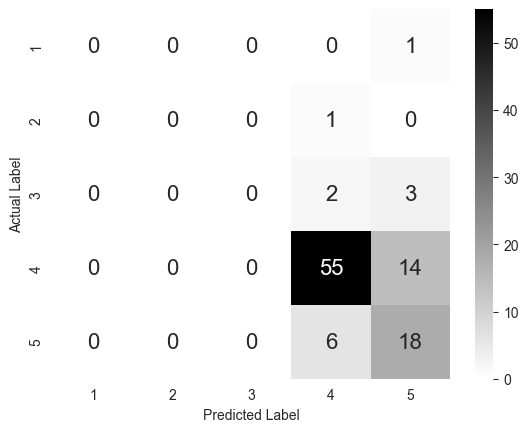

In [19]:
display_heatmap(return_matrix=False)  # change the parameter to True to return the NumPy array representation

The confusion matrix above summarizes the performance of the model by comparing actual labels with predicted labels. As shown in the first row, there were no instances of snippets with a readability label of 1 in the test set which were predicted to be 1. This is also the case for labels 2 and 3, although more snippets with a readability label of 3 were incorrectly predicted than those with labels 1 or 2. For labels 4 and 5, the classifier correctly predicted 55 and 18 instances, respectively, which is much more than the 0 correctly labeled instances for labels 1-3. However, it also incorrectly predicted 14 instances of label 4 as label 5 and 6 instances of label 5 as label 4; these are false positives.

The confusion matrix suggests that the model is performing well for predicting labels 4 and 5 but that it is struggling to differentiate between labels 1-3. Instances of misclassification for labels 4 and 5 are likely due to the fact that the two labels share almost all the same features, which makes label prediction more difficult.


In [20]:
display_importance()

Importance by Feature:
comments_docstrings: 50.66%
naming_conventions: 8.42%
descriptive_params: 7.73%
misc: 5.44%
line_length: 0.20%
whitespace_consistency: 0.00%
blank_lines: 0.00%


When we consider the importance of each feature, represented as the summation of the absolute values of each model's coefficients divided by the total number of models, we see that 3 of the 7 total features have an importance of less than 1%: line length, consistency with whitespace, and the number of blank lines. While it may be true that these unimportant features contribute to a programmer's assessment of the readability of Python code, it is likely the case that they do not contribute to the model's assessment ability. Perhaps these features are not present enough in the training data for the model to learn their importance.

On the contrary, the presence of inline comments and docstrings, proper naming conventions, descriptive parameters, and to-do statements/proper boolean comparisons are features with much higher importance: 50.66%, 8.42%, 7.73%, and 5.44% respectively. It is likely that these features are strongly correlated with code readability and have more of a presence in the training data as compared to the aforementioned unimportant features. Inline comments and docstrings, for example, tend to provide valuable information about the code they reference, such as its intended usage and functionality. Similarly, consistent naming conventions and descriptive parameters help to make code more self-explanatory and easier to comprehend, better conveying the purpose of variables and their values.

In order to improve our model's performance, as mentioned before, we could select the data from a wider range of Python repositories. In the ideal case, the proportion of data points that fall under each label would be equal, effectively eliminating the model's bias towards certain classes and potentially balancing out the importance of each feature. There is not much of a need for oversampling or adjusting class weights since there is an obvious imbalance in the proportion of data in each class. That being said, the best course of action for improving our model's accuracy is to collect a wider variety of Python snippets and then re-train the model.